Matching hankel function to solution to scrodinger equation

best E = -0.037192
best A = -43183053389.706734


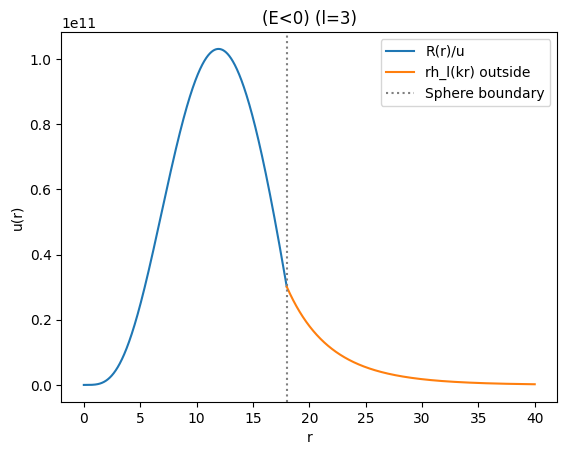

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.special import spherical_jn, spherical_yn

def spherical_hankel(l, x,k):

    j = (x/k)*spherical_jn(l, x)
    y = (x/k)*spherical_yn(l, x)
    h = -1j*(j + 1j*y)*1j**(l+1)

    dj = spherical_jn(l, x, derivative=True)
    dy = spherical_yn(l, x, derivative=True)

    # j1 = j +  x/k * dj
    # y1 = y +  x/k * dy

    # dh = -1j*(dj + 1j*dy)*1j**(l+1)
    dh_dx = -1j * (dj + 1j*dy) * (1j**(l+1))

    dh = k*h + x* dh_dx

    return h, dh

def schrod_ode(r, y, E, l):
    """
    second order ode to fisr order
    """
    u, up = y
    return [
    up,
    (l * (l + 1) / r**2 - 2.0 / r - E) * u
    ]

def schrod_int(E, l, boundary_conditions, r_min, R, num_points=3000):

    r_values = np.linspace(r_min, R, num_points)
    sol = solve_ivp(
        schrod_ode,
        (r_min, R),
        boundary_conditions,
        method='DOP853',
        t_eval=r_values,
        args=(E, l)
    )
    return r_values, sol.y[0], sol.y[1]

def residual_match(vars, l, boundary_conditions, r_min, R):

    E, A = vars

    if E <= 0:
        k = 1j*np.sqrt(np.abs(E))
    else:
        k = np.sqrt(E)

    r_vals, u_vals, up_vals = schrod_int(E, l, boundary_conditions, r_min, R)
    uR  = u_vals[-1]   # wavefunction at R
    upR = up_vals[-1]  # derivative at R

    h_val, dh_val = spherical_hankel(l, k * R,k)



    res1 = (uR- A * h_val).real

    res2 = (upR - A * (k*R*dh_val)).real

    return [res1, res2]

def solver(E_guess, A_guess, l, boundary_conditions, r_min, R):

    x0 = [E_guess, A_guess]
    sol = fsolve(
        residual_match,
        x0,
        args=(l, boundary_conditions, r_min, R),
        xtol=1e-12
    )
    return sol

def plotting(E_best, A_best, l, boundary_conditions, r_min, R,
                           r_extend=40, r_num=1000):

    r_in, u_in, up_in = schrod_int(E_best, l, boundary_conditions, r_min, R, r_num)

    plt.plot(r_in, u_in.real, label="R(r)/u")

    r_out = np.linspace(R, r_extend, r_num)
    if E_best <= 0:
        k = 1j*np.sqrt(np.abs(E_best))
    else:
        k = np.sqrt(E_best)

    hankel_vals,_=spherical_hankel(l,k*r_out,k)
    hankel_vals = A_best * hankel_vals


    plt.plot(r_out, hankel_vals.real, label="rh_l(kr) outside")


    plt.axvline(R, color='gray', linestyle=':', label="Sphere boundary")

    plt.xlabel("r")
    plt.ylabel("u(r)")
    plt.title(f"(E<0) (l={l})")
    plt.legend()
    plt.show()


if __name__ == "__main__":
    l = 3
    bc = [0.0, 1.0]
    r_min = 1e-3
    R = 18

    E_guess = -.6
    A_guess = -50.0
    E_best, A_best = solver(E_guess, A_guess, l, bc, r_min, R)

    print(f"best E = {E_best:.6f}")
    print(f"best A = {A_best:.6f}")

    plotting(E_best, A_best, l, bc, r_min, R, r_extend=40.0)

